## Balansiranje

In [35]:
import numpy as np  # Numerical Python
import matplotlib.pyplot as plt  # Python plotting
# Set the style for your plots
# plt.style.use('ggplot')
# import seaborn as sns
# # palettes = ['Paired', 'colorblind', 'inferno', 'coolwarm']
# sns.set_palette('Paired')
    
from scipy import signal
from scipy.fft import fft, fftshift

import numpy as np
import scipy.signal as signal


def open_txt_file(filename, n=8, m=3):
    '''the file itself has a header of n lines and than m number of colums. This function returns and array of m columns'''
    
    column1_data = []
    column2_data = []
    
    with open(filename, 'r') as file:

        # Skip the first n lines (header)
        for _ in range(n):
            next(file)

        # Read the remaining lines and extract data from the columns
        for line in file:
            columns = line.strip().split()
            if len(columns) == 2:
                column1_data.append(float(columns[0].strip()))
                column2_data.append(float(columns[1].strip()))
    
    return [np.array(column1_data), np.array(column2_data)]


def add_noise_to_signal(signal, noise_amplitude):
    noise = np.random.normal(scale=noise_amplitude, size=len(signal))
    return signal + noise



In [36]:
data = open_txt_file('meritve2/run1_0708.txt')
data[0][:10]

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 ])

### Debalans

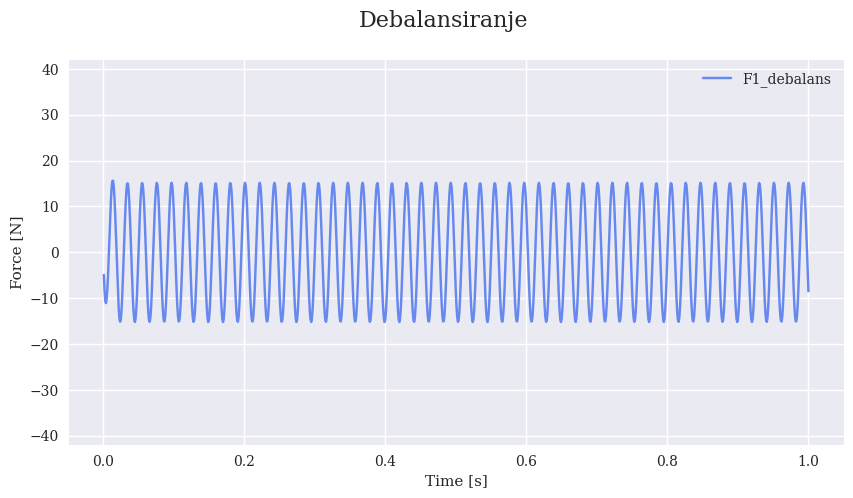

In [37]:
filename = 'meritve2/run1_0708.txt'
data = open_txt_file(filename)

Time = data[0]
t = Time
F1_debalans = data[1]

def print_data(data, Title, y1=-42, y2=42):
    '''data ima obliko [t, F1, F2]'''
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.suptitle(Title, fontsize=16)
    ax.plot(data[0], data[1], label='F1_debalans')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Force [N]')
    ax.set_ylim(y1, y2)
    ax.legend();

data_debalans = open_txt_file(filename)
data_debalans[1] = data_debalans[1] - np.mean(data_debalans[1])
print_data(data_debalans, Title='Debalansiranje')


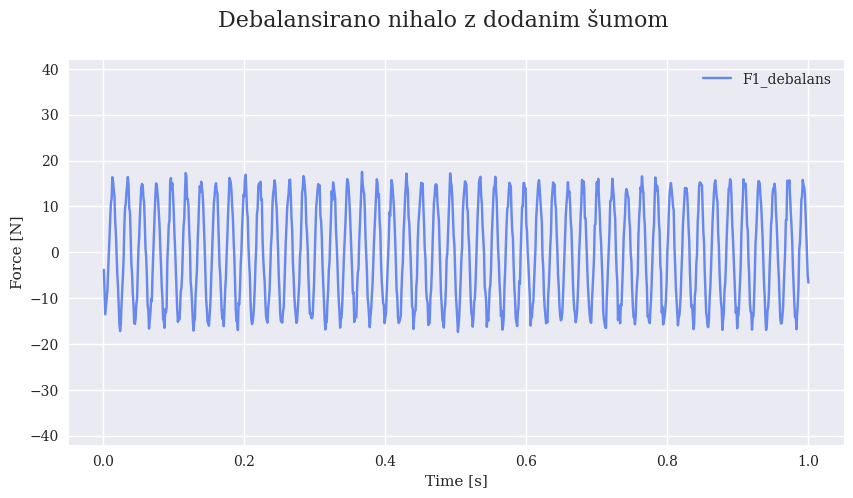

In [38]:
noise_amplitude = 1.2;
noise = np.random.normal(scale=noise_amplitude, size=len(t))
data_debalans_noise = data_debalans.copy()
data_debalans_noise[1] = data_debalans[1] + noise

print_data(data_debalans_noise, Title='Debalansirano nihalo z dodanim šumom')

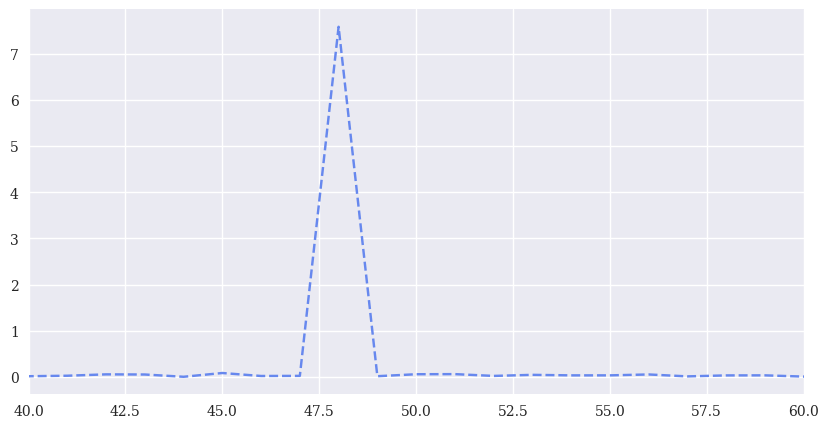

In [39]:
def Fourier(data):
    dt = data[0][1] - data[0][0]
    freq = np.fft.rfftfreq(len(data[0]), dt)
    Fourier_data = np.fft.rfft(data[1], norm="forward");

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(freq, np.abs(Fourier_data), '--')
    ax.set_xlim(40, 60)
    # freq
Fourier(data_debalans_noise)

In [40]:
# freq_F = 6;
# sos = signal.butter(3, [0.95*freq_F, 1.05*freq_F], 'bandpass', fs=1001, output='sos')
# filtriran_debalans = data_debalans.copy()
# filtriran_debalans[1] = signal.sosfiltfilt(sos, data_debalans_noise[1])#*np.hanning(len(Time)))
# filtriran_debalans[2] = signal.sosfiltfilt(sos, data_debalans_noise[2]*np.hanning(len(Time)))

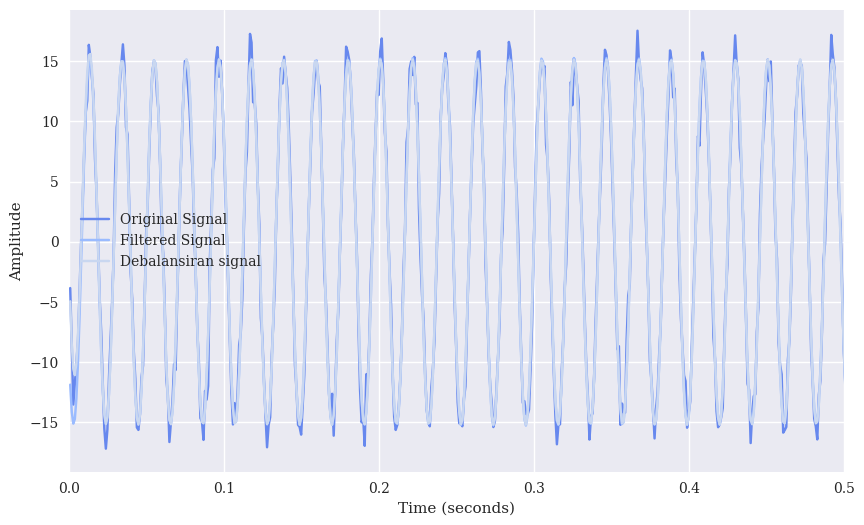

In [41]:
def filtriranje(t, original_signal, sampling_rate=1000, low_cutoff_freq=45.7, high_cutoff_freq=50.3):
    # Step 1: Compute the FFT of the original signal
    fft_signal = np.fft.fft(original_signal)

    # Step 2: Apply a frequency-domain filter (e.g., zero out frequencies outside a specific range)
    # Design the frequency domain filter (e.g., band-pass filter)
    freq_range = (low_cutoff_freq, high_cutoff_freq)
    filtered_fft_signal = np.copy(fft_signal)
    freqs = np.fft.fftfreq(len(fft_signal), d=1/sampling_rate)
    filtered_fft_signal[(freqs < freq_range[0]) | (freqs > freq_range[1])] = 0

    # Step 3: Compute the Inverse FFT to get the filtered signal in the time domain
    filtered_signal = 2*np.fft.ifft(filtered_fft_signal)
    return filtered_signal

filtered_signal = filtriranje(t=t, original_signal=data_debalans_noise[1], low_cutoff_freq=45.7, high_cutoff_freq=50.3)
# Plot the original and filtered signals
plt.figure(figsize=(10, 6))
plt.plot(t, data_debalans_noise[1], label='Original Signal')
plt.plot(t, filtered_signal.real, label='Filtered Signal')
plt.plot(t, data_debalans[1], label='Debalansiran signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim(0, 0.5)
plt.legend()
plt.grid(True)
plt.show()



In [42]:
1000/20.8333333332

48.0000000003072

In [43]:
frekvenca_vrtenja = 48
# deljenec = 62

def find_and_print_peaks(signal_array, min_peak_distance=50):
    peaks, _ = signal.find_peaks(signal_array, distance=min_peak_distance)
    print("Peaks found at indices:", peaks)
    return peaks

peaks_debalans = find_and_print_peaks(data_debalans[1], min_peak_distance=50)
peaks_filtered = find_and_print_peaks(filtered_signal.real, min_peak_distance=50)

def amplitude_and_phase(signal_array, peaks, deljenec=62):
    amplitude = np.average(np.abs(signal_array[peaks]))
    dif = []
    for i in np.arange(len(peaks)-1):
        dif.append(peaks[i+1]-peaks[i])
    phase = peaks[4]%(deljenec)/np.average(dif) * 360
    print(f'Amplituda debalans = {amplitude:.3f} N')
    print(f'Faza debalans = {phase:.3f} stopinj')
    return amplitude, phase

A_u, phase_u = amplitude_and_phase(data_debalans[1], peaks_debalans)
A_u1, phase_u1 = amplitude_and_phase(filtered_signal.real, peaks_filtered)
# Example usage with a cleaner signal
# cleaner_signal = filtered_signal
# min_peak_distance = 50  # Set the minimum peak distance as needed

# peaks = find_and_print_peaks(cleaner_signal, min_peak_distance)
# peaks2 = find_and_print_peaks(data_debalans[1], min_peak_distance)

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(t, data_debalans[1], label='Original Signal')
# ax.plot(t, filtered_signal.real, label='Filtered Signal')
# ax.plot(t[peaks], filtered_signal[peaks].real, 'x', label='Detected Peaks_filtered')
# ax.plot(t[peaks2], data_debalans[1][peaks2], 'x', label='Detected Peaks_original')
# ax.set_xlabel('Time')
# ax.set_ylabel('Amplitude')
# ax.legend()
# ax.grid(True)


Peaks found at indices: [ 13  96 158 221 283 346 408 471 533 596 658 721 783 846 908 971]
Peaks found at indices: [ 13  96 159 221 284 346 450 513 596 679 742 846 950]
Amplituda debalans = 15.106 N
Faza debalans = 197.286 stopinj
Amplituda debalans = 15.132 N
Faza debalans = 165.977 stopinj


### Testna masa

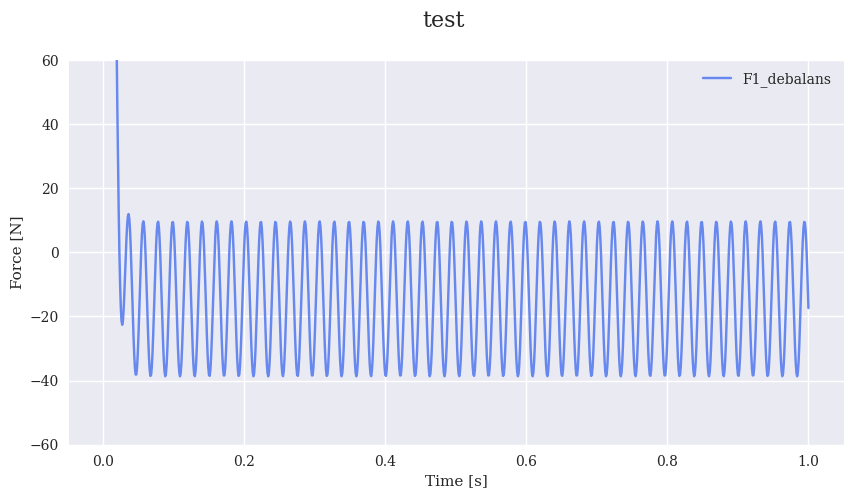

In [44]:
filename = 'meritve2/run2_0708.txt'
data = open_txt_file(filename)

Time = data[0]
t = Time
F1_debalans = data[1]

data_test = open_txt_file(filename)
data_test[1] = data_test[1] - np.mean(data_test[1])
print_data(data_test, Title='test', y1=-60, y2=60)



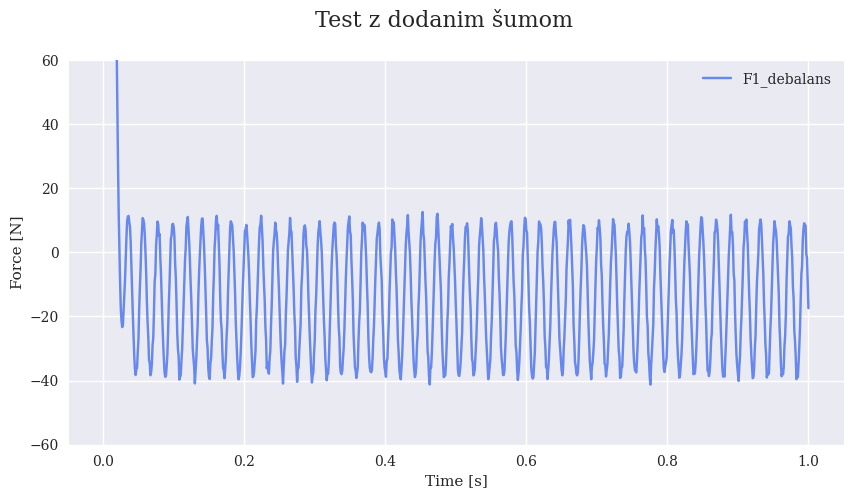

In [45]:
noise_amplitude = 1.2;
noise = np.random.normal(scale=noise_amplitude, size=len(t))
data_test_noise = data_test.copy()
data_test_noise[1] = data_test[1] + noise

print_data(data_test_noise, Title='Test z dodanim šumom', y1=-60, y2=60)

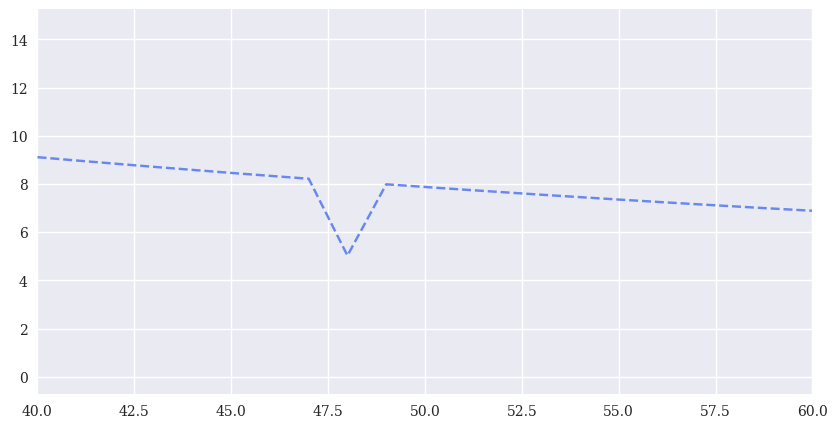

In [46]:
Fourier(data_test_noise)

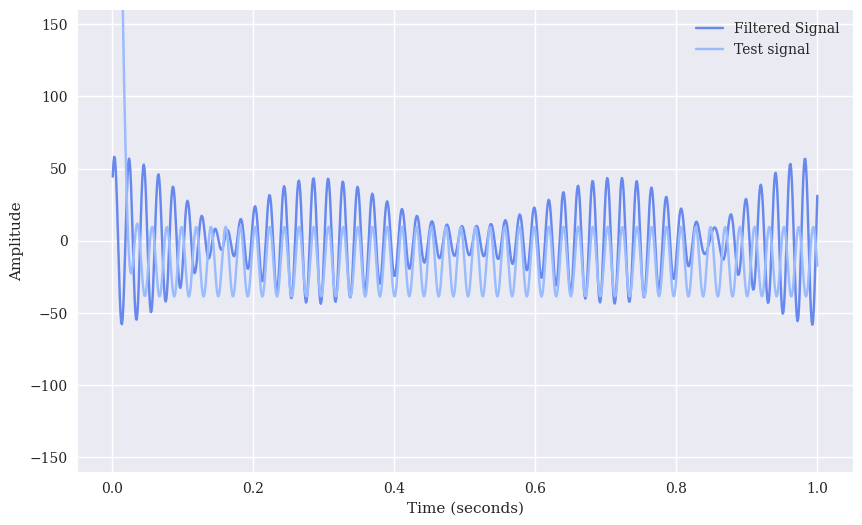

In [47]:
filtered_signal_test = filtriranje(t=t, original_signal=data_test_noise[1], low_cutoff_freq=47.7, high_cutoff_freq=48.3)
# Plot the original and filtered signals
plt.figure(figsize=(10, 6))
# plt.plot(t, data_test_noise[1], label='Original Signal')
plt.plot(t, filtered_signal_test.real, label='Filtered Signal')
plt.plot(t, data_test[1], label='Test signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.ylim([-160, 160])
plt.legend()
plt.grid(True)
plt.show()

In [48]:
# def find_and_print_peaks(signal_array, min_peak_distance=50):
#     peaks, _ = signal.find_peaks(data_test[1], distance=min_peak_distance)
#     # print("Peaks found at indices:", peaks)
#     return peaks

peaks_test = find_and_print_peaks(data_test[1], min_peak_distance=40)
peaks_test1 = find_and_print_peaks(filtered_signal_test.real, min_peak_distance=40)

# def amplitude_and_phase(signal_array, peaks):
#     amplitude = np.average(np.abs(signal_array[peaks]))
#     dif = []
#     for i in np.arange(len(peaks)-1):
#         dif.append(peaks[i+1]-peaks[i])
#     phase = peaks[0]/np.average(dif) * 360
#     print(f'Amplituda debalans = {amplitude:.3f} N')
#     print(f'Faza debalans = {phase:.3f} stopinj')
#     return amplitude, phase

A_uw, phase_uw = amplitude_and_phase(data_test[1], peaks_test)
A_uw1, phase_uw1 = amplitude_and_phase(filtered_signal_test.real, peaks_test1)

Peaks found at indices: [ 35  77 118 160 202 243 285 327 368 410 452 493 535 577 618 660 702 743
 785 827 868 910 952 993]
Peaks found at indices: [  2  44  85 126 202 243 285 326 368 410 453 516 557 598 639 680 722 764
 806 853 898 940 982]
Amplituda debalans = 9.619 N
Faza debalans = 138.288 stopinj
Amplituda debalans = 32.428 N
Faza debalans = 129.306 stopinj


In [49]:
phase_u, phase_uw

(197.28601252609602, 138.28810020876827)

### Izračun korekcije

In [50]:
print(peaks_debalans)
print(peaks_test)
print(peaks_debalans[:5] - peaks_test[:5])

[ 13  96 158 221 283 346 408 471 533 596 658 721 783 846 908 971]
[ 35  77 118 160 202 243 285 327 368 410 452 493 535 577 618 660 702 743
 785 827 868 910 952 993]
[-22  19  40  61  81]


In [51]:
debalans = data_debalans.copy()
debalans[1] = filtered_signal.real
test = data_test.copy()
test[1] = filtered_signal_test.real

In [52]:
360 - 146/166 *360

43.373493975903614

${A_w}^2 = {A_{v+w}}^2 + {A_v}^2 - 2 A_v A_{v+w} \cdot cos(\alpha)$

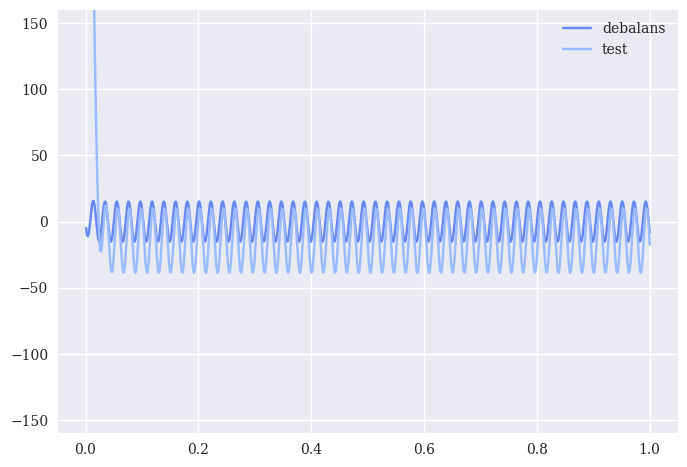

In [53]:
plt.plot(t, data_debalans[1], label='debalans')
plt.plot(t, data_test[1], label='test')
plt.ylim(-160, 160)
plt.legend()

In [54]:
A = np.array([10*np.cos(np.pi/6), 10*np.sin(np.pi/6)])
B = A - 10
B

array([-1.33974596, -5.        ])

In [55]:
np.arange(10) * 166 +1

array([   1,  167,  333,  499,  665,  831,  997, 1163, 1329, 1495])

In [56]:
def analiza(data1, data2, m_w, name1="Debalans", name2="Test"):
    
    ref = np.zeros_like(data1[1])
    for i in [0, 167, 333, 499, 655, 831, 997]:
        ref[i] = 100
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(data1[0], data1[1], label=f'{name1}')
    ax.plot(data2[0], data2[1], label=f'{name2}')
    ax.plot(data1[0], ref, label='Referenca')
    ax.legend()
    
    peaks1 = find_and_print_peaks(data1[1], min_peak_distance=140)
    peaks2 = find_and_print_peaks(data2[1], min_peak_distance=140)
    
    ax.plot(data1[0][peaks1], data1[1][peaks1], 'x', label='peaks1')
    ax.plot(data2[0][peaks2], data2[1][peaks2], 'x', label='peaks2')
    
    A_1, phase_1 = amplitude_and_phase(data1[1], peaks1)
    A_2, phase_2 = amplitude_and_phase(data2[1], peaks2)
    print()
    print()
    print(f'A_u = {A_1:.3f} N')
    print(f'phi_u = {phase_1:.3f} deg')
    print()
    print(f'A_uw = {A_2:.3f} N')
    print(f'phi_uw = {phase_2:.3f} deg')
    
    alpha1 = (phase_1 - phase_2) * np.pi / 180
    A_w = np.sqrt(A_2**2 + A_1**2 - 2*A_2*A_1*np.cos(alpha1))
    
    # alpha2_arccos = (A_u**2 + A_w**2 - A_uw**2)/(2*A_u*A_w)
    alpha2 = np.arccos((A_u**2 + A_w**2 - A_uw**2)/(2*A_u*A_w))
    print()
    print('Korekcijski podatki:')
    print(f'alpha 2 = {(alpha2*180/np.pi):.3f} deg')
    print(f'm_0 = {A_1/A_w * m_w} N')
    return A_1, phase_1, A_2, phase_2


Peaks found at indices: [ 13 221 471 700 846 992]
Peaks found at indices: [ 35 181 410 660 910]
Amplituda debalans = 15.223 N
Faza debalans = 73.544 stopinj
Amplituda debalans = 10.061 N
Faza debalans = 69.120 stopinj


A_u = 15.223 N
phi_u = 73.544 deg

A_uw = 10.061 N
phi_uw = 69.120 deg

Korekcijski podatki:
alpha 2 = nan deg
m_0 = 4.639885003279878 N


C:\Users\marko\AppData\Local\Temp\ipykernel_11832\2375514343.py:32: RuntimeWarning: invalid value encountered in arccos
  alpha2 = np.arccos((A_u**2 + A_w**2 - A_uw**2)/(2*A_u*A_w))


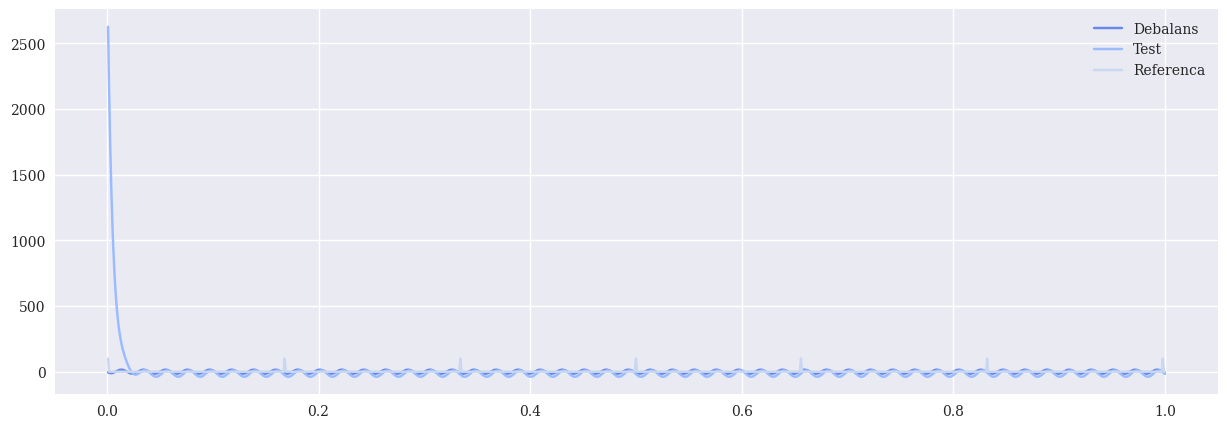

In [57]:
A_u, phase_u, A_uw, phase_uw = analiza(data_debalans, data_test, m_w=1.6)

${A_w}^2 = {A_{v+w}}^2 + {A_v}^2 - 2 A_v A_{v+w} \cdot cos(\alpha)$

Peaks found at indices: [ 54 200 346 492 700 846 992]
Peaks found at indices: [  2 145 285 431 577 722 982]
Amplituda debalans = 15.161 N
Faza debalans = 41.450 stopinj
Amplituda debalans = 35.007 N
Faza debalans = 41.878 stopinj


A_u = 15.161 N
phi_u = 41.450 deg

A_uw = 35.007 N
phi_uw = 41.878 deg

Korekcijski podatki:
alpha 2 = 29.789 deg
m_0 = 1.2222891970962722 N


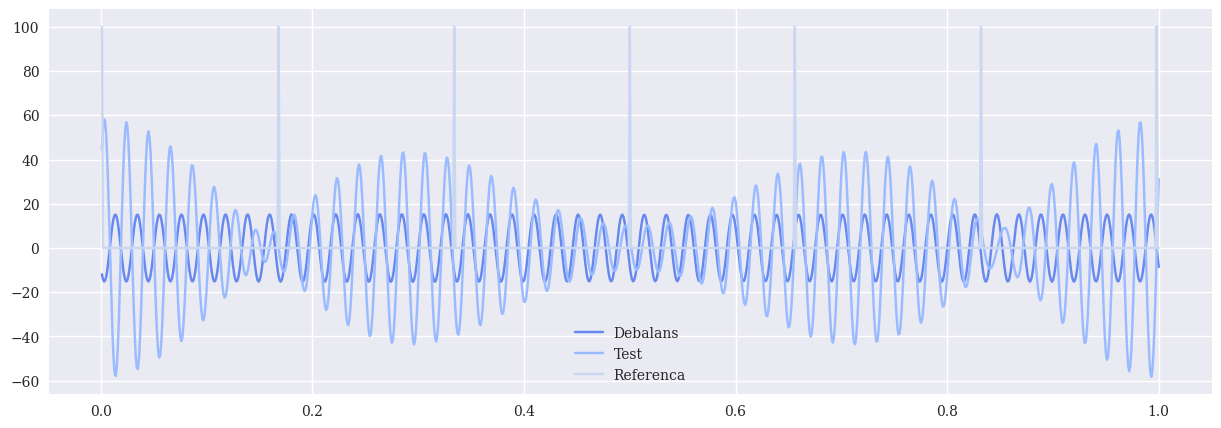

In [58]:
A_u2, phase_u2, A_uw2, phase_uw2 = analiza(debalans, test, m_w=1.6)

### Polarni diagrami

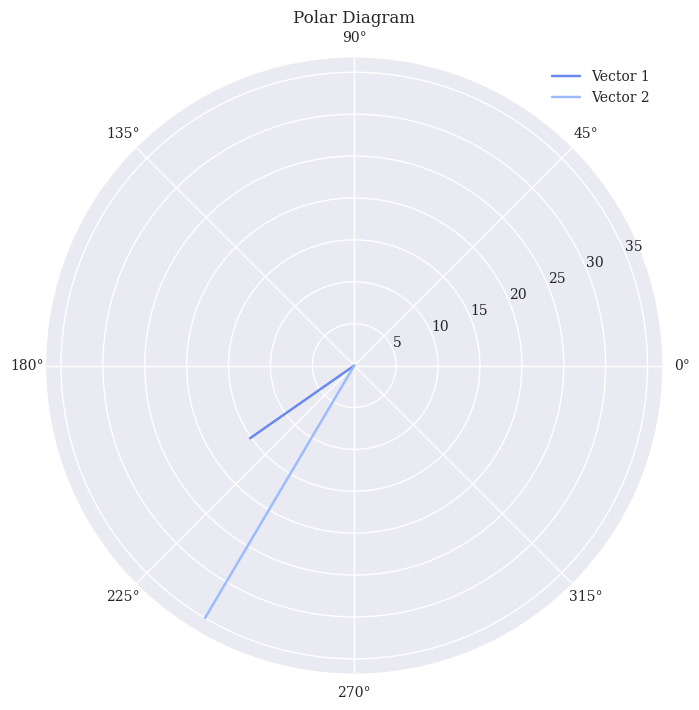

In [59]:

A_u2, phase_u2, A_uw2, phase_uw2

# A_u2 = 1.5
# phase_u2 = np.deg2rad(30)  # Convert phase from degrees to radians

# A_uw2 = 2.0
# phase_uw2 = np.deg2rad(60)  # Convert phase from degrees to radians

# Convert polar coordinates to Cartesian coordinates
x_vector1 = A_u2 * np.cos(phase_u2)
y_vector1 = A_u2 * np.sin(phase_u2)

x_vector2 = A_uw2 * np.cos(phase_uw2)
y_vector2 = A_uw2 * np.sin(phase_uw2)

# Plot the polar diagram
plt.figure(figsize=(8, 8))
plt.polar([0, phase_u2], [0, A_u2], label='Vector 1')
plt.polar([0, phase_uw2], [0, A_uw2], label='Vector 2')
plt.legend()
plt.title('Polar Diagram')
plt.grid(True)
plt.show()


In [60]:
A_u2, phase_u2, A_uw2, phase_uw2
phase_u2 = np.deg2rad(phase_u2)
phase_uw2 = np.deg2rad(phase_uw2)

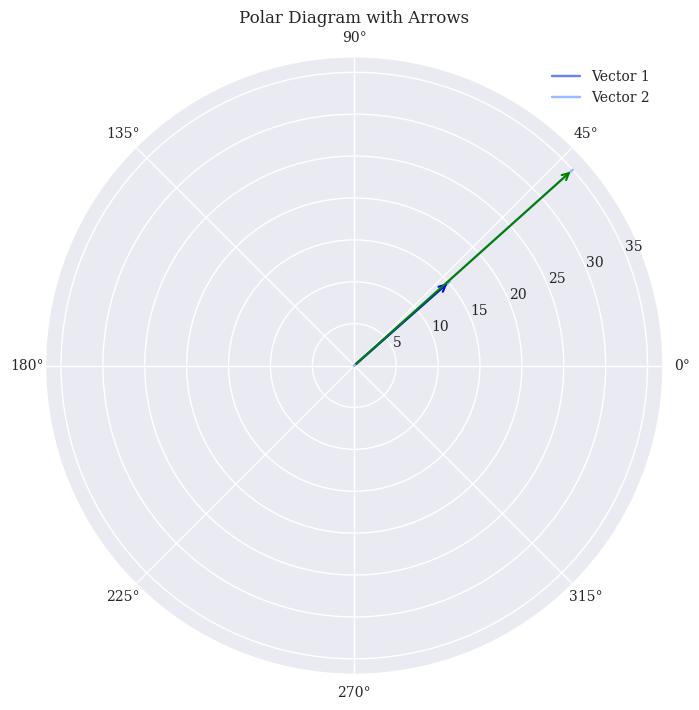

In [61]:
x_vector1 = A_u2 * np.cos(phase_u2)
y_vector1 = A_u2 * np.sin(phase_u2)

x_vector2 = A_uw2 * np.cos(phase_uw2)
y_vector2 = A_uw2 * np.sin(phase_uw2)

A_u2, phase_u2, A_uw2, phase_uw2

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

# Add arrows for Vector 1
ax.plot([0, phase_u2], [0, A_u2], label='Vector 1')
arrowprops_vector1 = dict(arrowstyle='->', linewidth=1.5, color='blue')
ax.annotate("", xy=(phase_u2, A_u2), xytext=(0, 0), arrowprops=arrowprops_vector1)

# Add arrows for Vector 2
ax.plot([0, phase_uw2], [0, A_uw2], label='Vector 2')
arrowprops_vector2 = dict(arrowstyle='->', linewidth=1.5, color='green')
ax.annotate("", xy=(phase_uw2, A_uw2), xytext=(0, 0), arrowprops=arrowprops_vector2)

ax.legend()
ax.set_title('Polar Diagram with Arrows')
ax.grid(True)

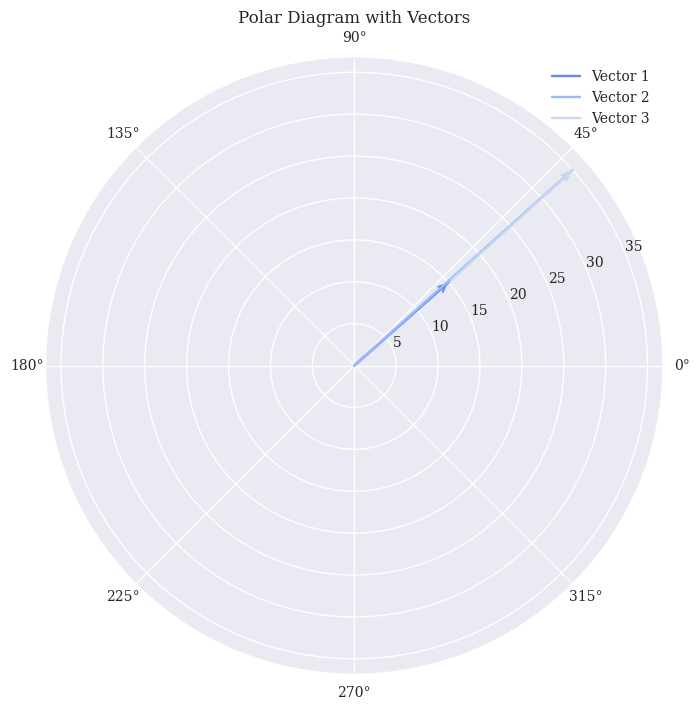

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Amplitudes and phases for the two vectors
amplitude_vector1 = A_u2
phase_vector1 = phase_u2  # Convert phase from degrees to radians

amplitude_vector2 = A_uw2
phase_vector2 = phase_uw2  # Convert phase from degrees to radians

# Convert polar coordinates to Cartesian coordinates
x_vector1 = amplitude_vector1 * np.cos(phase_vector1)
y_vector1 = amplitude_vector1 * np.sin(phase_vector1)

x_vector2 = amplitude_vector2 * np.cos(phase_vector2)
y_vector2 = amplitude_vector2 * np.sin(phase_vector2)

# Compute the Cartesian coordinates for the vector connecting the end of vector one to the end of vector two
x_vector3 = x_vector2 - x_vector1
y_vector3 = y_vector2 - y_vector1

# Compute the amplitude and phase of the new vector
amplitude_vector3 = np.sqrt(x_vector3**2 + y_vector3**2)
phase_vector3 = np.arctan2(y_vector3, x_vector3)

# Convert the phase of the new vector to degrees
phase_vector3_degrees = np.rad2deg(phase_vector3)

# Plot the polar diagram with arrows for all three vectors
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

# Add arrows for Vector 1
ax.plot([0, phase_vector1], [0, amplitude_vector1], label='Vector 1')
arrowprops_vector1 = dict(arrowstyle='->', linewidth=1.5, color='C0')
ax.annotate("", xy=(phase_vector1, amplitude_vector1), xytext=(0, 0), arrowprops=arrowprops_vector1)

# Add arrows for Vector 2
ax.plot([0, phase_vector2], [0, amplitude_vector2], label='Vector 2')
arrowprops_vector2 = dict(arrowstyle='->', linewidth=1.5, color='C1')
ax.annotate("", xy=(phase_vector2, amplitude_vector2), xytext=(0, 0), arrowprops=arrowprops_vector2)

# Add the vector connecting the end of vector one to the end of vector two
ax.plot([phase_vector1, phase_vector2], [amplitude_vector1, amplitude_vector2], label='Vector 3')
arrowprops_vector3 = dict(arrowstyle='->', linewidth=1.5, color='C2')
ax.annotate("", xy=(phase_vector2, amplitude_vector2), xytext=(phase_vector1, amplitude_vector1), arrowprops=arrowprops_vector3)

ax.legend()
ax.set_title('Polar Diagram with Vectors')
ax.grid(True)
plt.show()


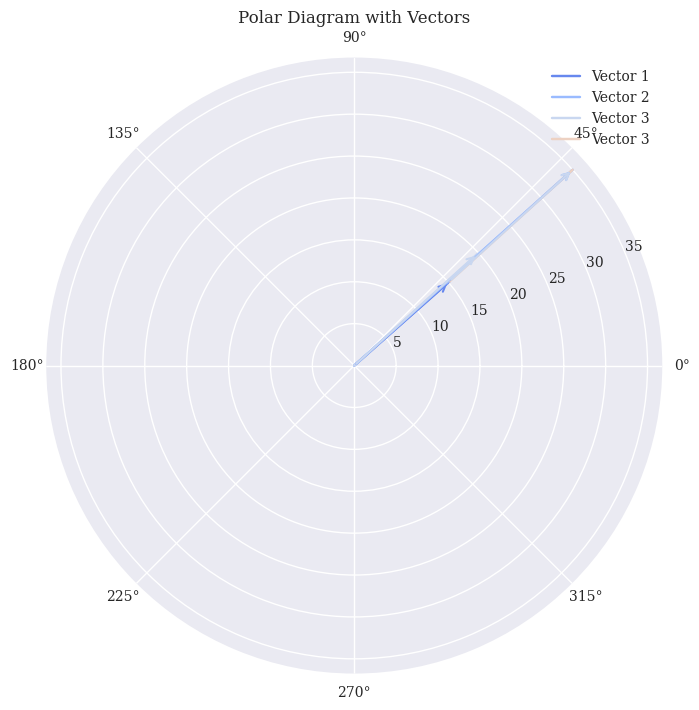

In [63]:
# Plot the polar diagram with arrows for all three vectors
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

# Add arrows for Vector 1
ax.plot([0, phase_vector1], [0, amplitude_vector1], label='Vector 1')
arrowprops_vector1 = dict(arrowstyle='->', linewidth=1.5, color='C0')
ax.annotate("", xy=(phase_vector1, amplitude_vector1), xytext=(0, 0), arrowprops=arrowprops_vector1)

# Add arrows for Vector 2
ax.plot([0, phase_vector2], [0, amplitude_vector2], label='Vector 2')
arrowprops_vector2 = dict(arrowstyle='->', linewidth=1.5, color='C1')
ax.annotate("", xy=(phase_vector2, amplitude_vector2), xytext=(0, 0), arrowprops=arrowprops_vector2)

# Add arrows for Vector 3
ax.plot([0, phase_vector3], [0, amplitude_vector3], label='Vector 3')
arrowprops_vector3 = dict(arrowstyle='->', linewidth=1.5, color='C2')
ax.annotate("", xy=(phase_vector3, amplitude_vector3), xytext=(0, 0), arrowprops=arrowprops_vector3)

# Add the vector connecting the end of vector one to the end of vector two
ax.plot([phase_vector1, phase_vector2], [amplitude_vector1, amplitude_vector2], label='Vector 3')
arrowprops_vector3 = dict(arrowstyle='->', linewidth=1.5, color='C2')
ax.annotate("", xy=(phase_vector2, amplitude_vector2), xytext=(phase_vector1, amplitude_vector1), arrowprops=arrowprops_vector3)

ax.legend()
ax.set_title('Polar Diagram with Vectors')
ax.grid(True)
plt.show()


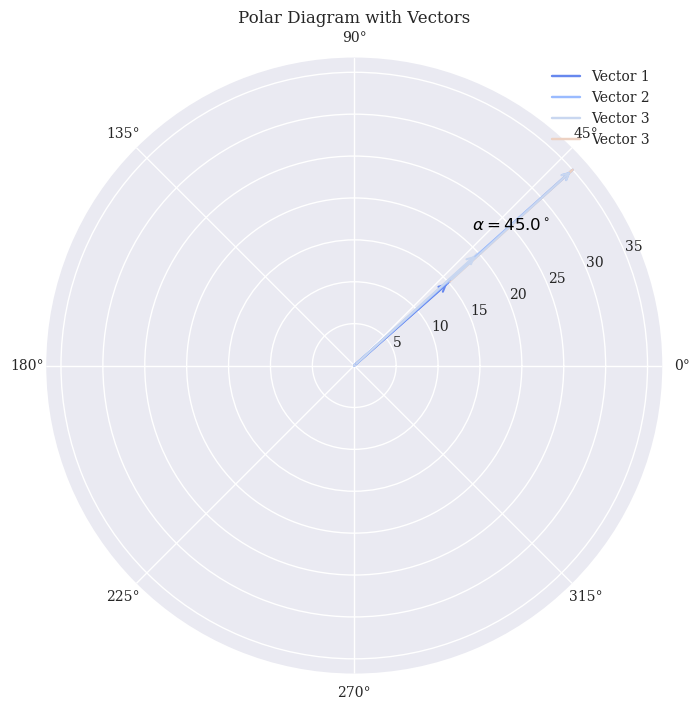

In [64]:
# Plot the polar diagram with arrows for all three vectors
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

# Add arrows for Vector 1
ax.plot([0, phase_vector1], [0, amplitude_vector1], label='Vector 1')
arrowprops_vector1 = dict(arrowstyle='->', linewidth=1.5, color='C0')
ax.annotate("", xy=(phase_vector1, amplitude_vector1), xytext=(0, 0), arrowprops=arrowprops_vector1)

# Add arrows for Vector 2
ax.plot([0, phase_vector2], [0, amplitude_vector2], label='Vector 2')
arrowprops_vector2 = dict(arrowstyle='->', linewidth=1.5, color='C1')
ax.annotate("", xy=(phase_vector2, amplitude_vector2), xytext=(0, 0), arrowprops=arrowprops_vector2)

# Add arrows for Vector 3
ax.plot([0, phase_vector3], [0, amplitude_vector3], label='Vector 3')
arrowprops_vector3 = dict(arrowstyle='->', linewidth=1.5, color='C2')
ax.annotate("", xy=(phase_vector3, amplitude_vector3), xytext=(0, 0), arrowprops=arrowprops_vector3)

# Add the vector connecting the end of vector one to the end of vector two
ax.plot([phase_vector1, phase_vector2], [amplitude_vector1, amplitude_vector2], label='Vector 3')
arrowprops_vector3 = dict(arrowstyle='->', linewidth=1.5, color='C2')
ax.annotate("", xy=(phase_vector2, amplitude_vector2), xytext=(phase_vector1, amplitude_vector1), arrowprops=arrowprops_vector3)

# Calculate the angle between Vector 1 and Vector 2
alpha = np.rad2deg(np.arctan2(amplitude_vector2 - amplitude_vector1, phase_vector2 - phase_vector1))
if alpha < 0:
    alpha += 360

# Add the angle "alpha" as text annotation
ax.text((phase_vector1 + phase_vector2) / 2, (amplitude_vector1 + amplitude_vector2) / 2,
        fr"$\alpha = {alpha/2:.1f}^\circ$", ha='center', va='center', fontsize=12, color='black')

ax.legend()
ax.set_title('Polar Diagram with Vectors')
ax.grid(True)
plt.show()

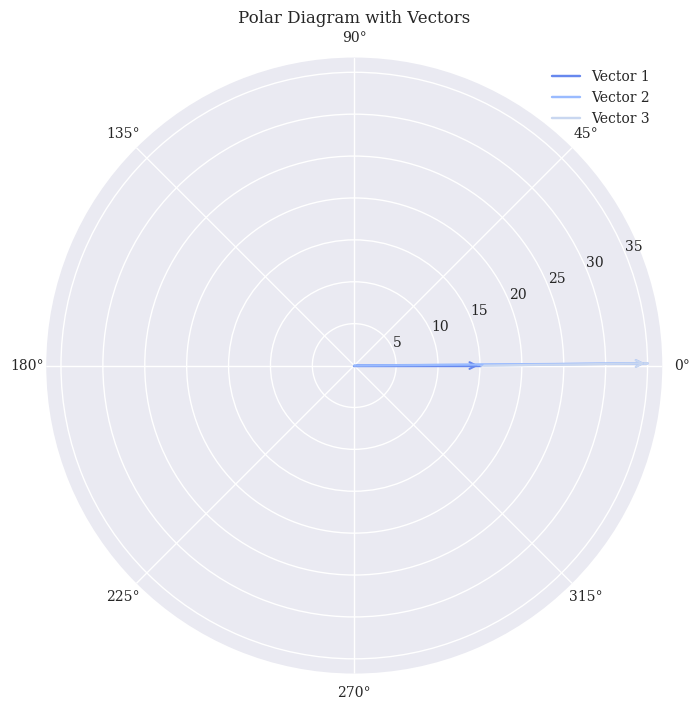

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Amplitudes and phases for the two vectors
amplitude_vector1 = A_u2
phase_vector1 = phase_u2 - phase_u2  # Convert phase from degrees to radians

amplitude_vector2 = A_uw2
phase_vector2 = phase_uw2 - phase_u2    # Convert phase from degrees to radians

# Convert polar coordinates to Cartesian coordinates
x_vector1 = amplitude_vector1 * np.cos(phase_vector1)
y_vector1 = amplitude_vector1 * np.sin(phase_vector1)

x_vector2 = amplitude_vector2 * np.cos(phase_vector2)
y_vector2 = amplitude_vector2 * np.sin(phase_vector2)

# Compute the Cartesian coordinates for the vector connecting the end of vector one to the end of vector two
x_vector3 = x_vector2 - x_vector1
y_vector3 = y_vector2 - y_vector1

# Compute the amplitude and phase of the new vector
amplitude_vector3 = np.sqrt(x_vector3**2 + y_vector3**2)
phase_vector3 = np.arctan2(y_vector3, x_vector3)

# Convert the phase of the new vector to degrees
phase_vector3_degrees = np.rad2deg(phase_vector3)

# Plot the polar diagram with arrows for all three vectors
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

# Add arrows for Vector 1
ax.plot([0, phase_vector1], [0, amplitude_vector1], label='Vector 1')
arrowprops_vector1 = dict(arrowstyle='->', linewidth=1.5, color='C0')
ax.annotate("", xy=(phase_vector1, amplitude_vector1), xytext=(0, 0), arrowprops=arrowprops_vector1)

# Add arrows for Vector 2
ax.plot([0, phase_vector2], [0, amplitude_vector2], label='Vector 2')
arrowprops_vector2 = dict(arrowstyle='->', linewidth=1.5, color='C1')
ax.annotate("", xy=(phase_vector2, amplitude_vector2), xytext=(0, 0), arrowprops=arrowprops_vector2)

# Add the vector connecting the end of vector one to the end of vector two
ax.plot([phase_vector1, phase_vector2], [amplitude_vector1, amplitude_vector2], label='Vector 3')
arrowprops_vector3 = dict(arrowstyle='->', linewidth=1.5, color='C2')
ax.annotate("", xy=(phase_vector2, amplitude_vector2), xytext=(phase_vector1, amplitude_vector1), arrowprops=arrowprops_vector3)

ax.legend()
ax.set_title('Polar Diagram with Vectors')
ax.grid(True)
plt.show()


C:\Users\marko\AppData\Local\Temp\ipykernel_11832\4269783665.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style)  # Set the current style


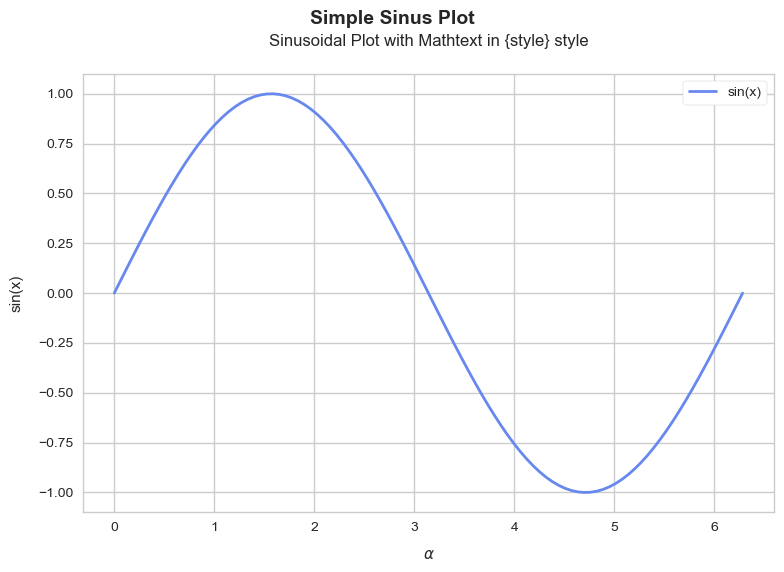

C:\Users\marko\AppData\Local\Temp\ipykernel_11832\4269783665.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style)  # Set the current style


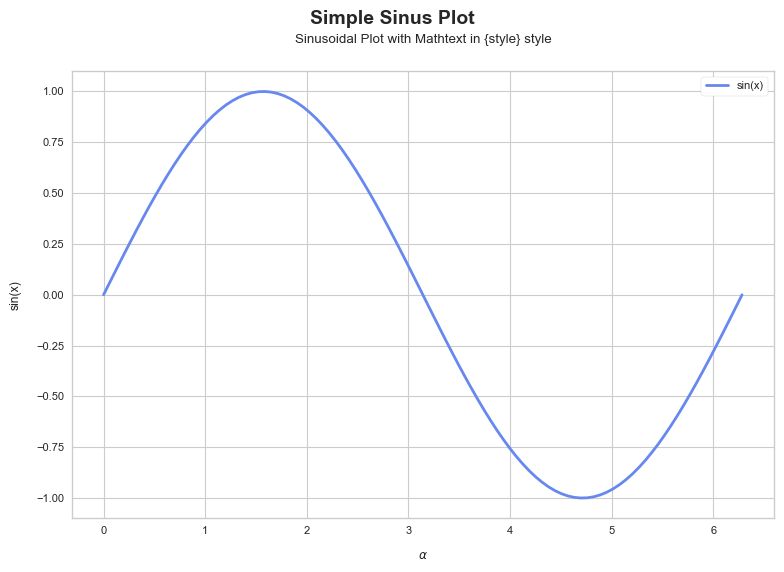

C:\Users\marko\AppData\Local\Temp\ipykernel_11832\4269783665.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style)  # Set the current style


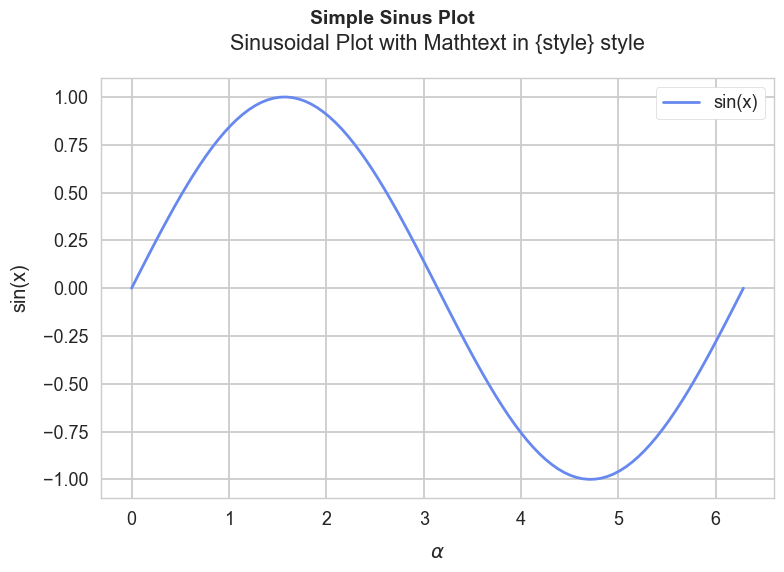

C:\Users\marko\AppData\Local\Temp\ipykernel_11832\4269783665.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style)  # Set the current style


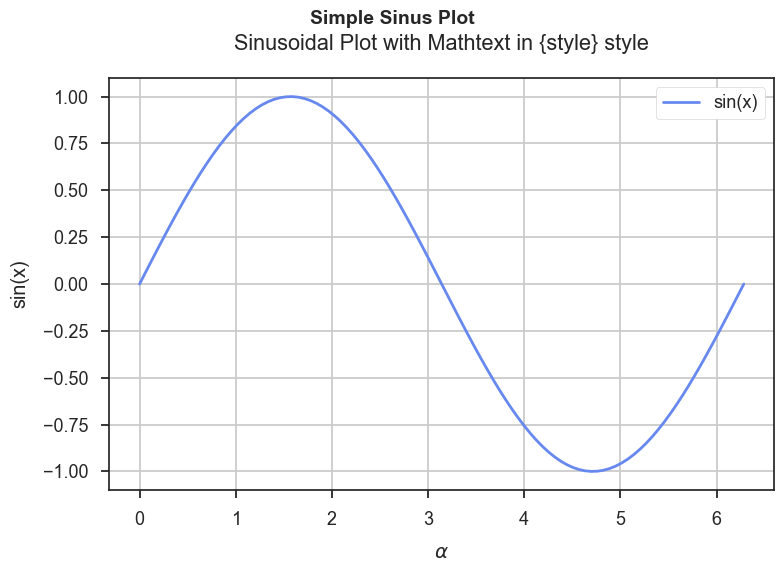

C:\Users\marko\AppData\Local\Temp\ipykernel_11832\4269783665.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style)  # Set the current style


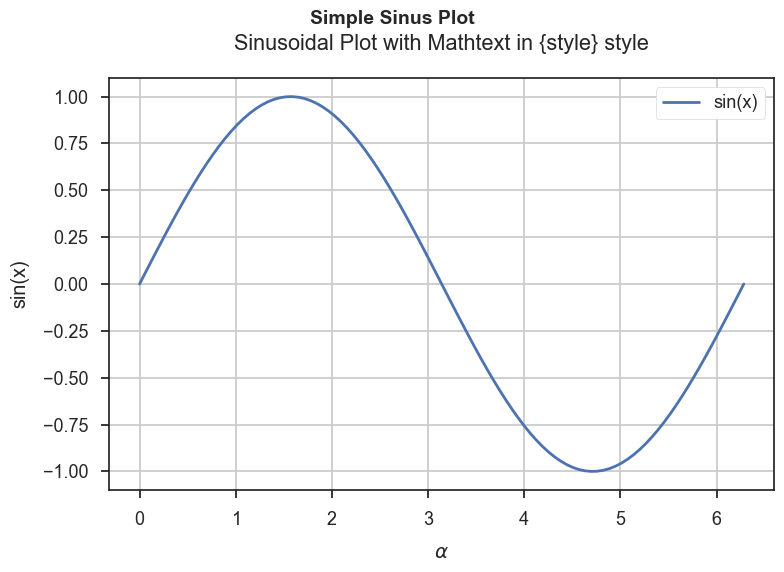

C:\Users\marko\AppData\Local\Temp\ipykernel_11832\4269783665.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style)  # Set the current style


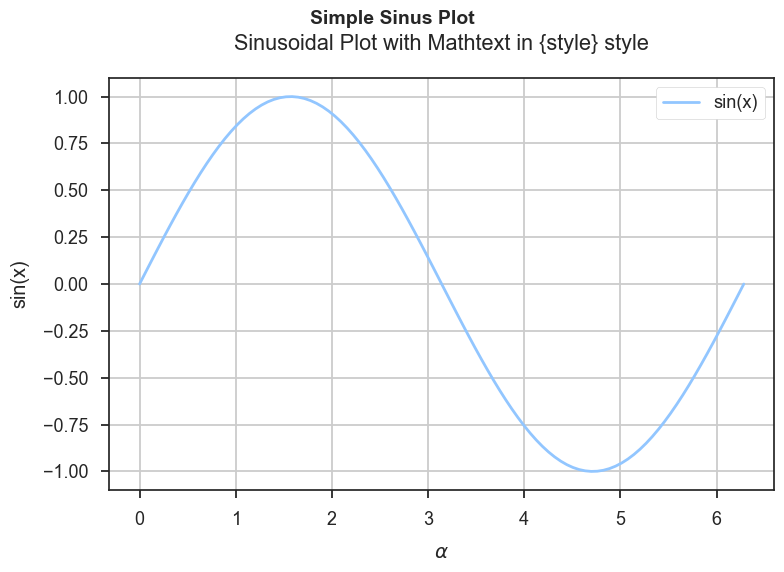

C:\Users\marko\AppData\Local\Temp\ipykernel_11832\4269783665.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style)  # Set the current style


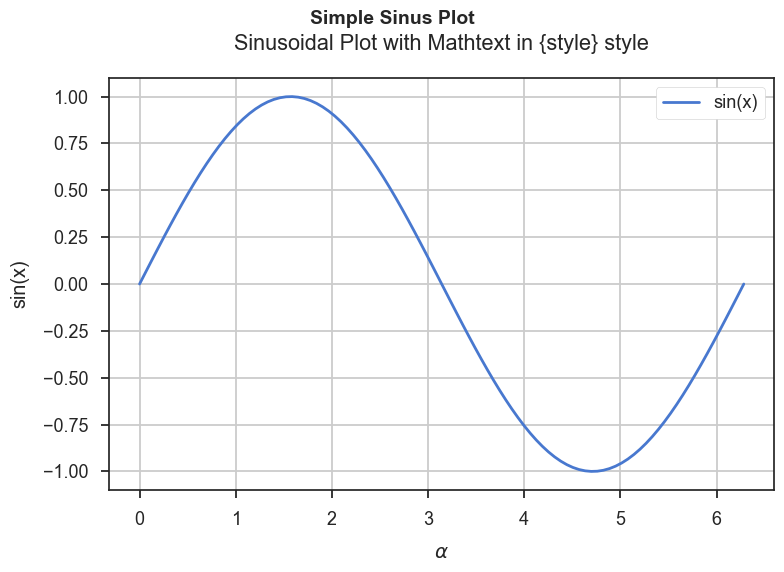

C:\Users\marko\AppData\Local\Temp\ipykernel_11832\4269783665.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style)  # Set the current style


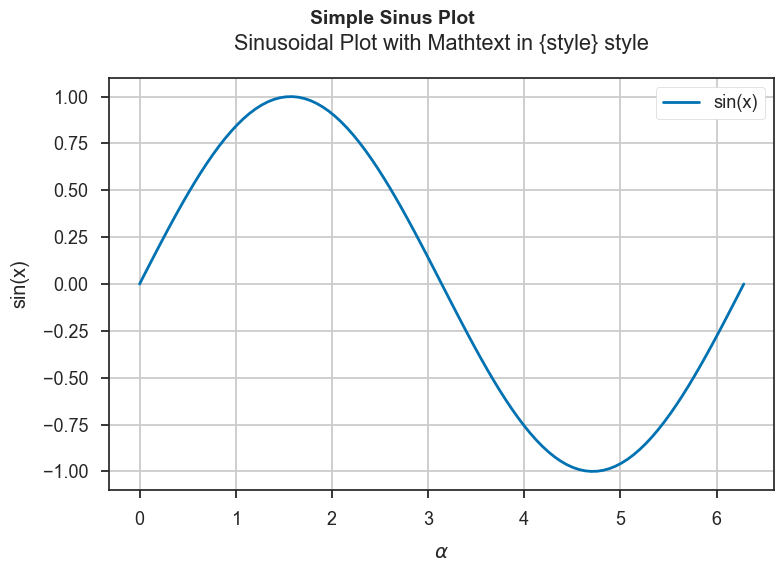

C:\Users\marko\AppData\Local\Temp\ipykernel_11832\4269783665.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style)  # Set the current style


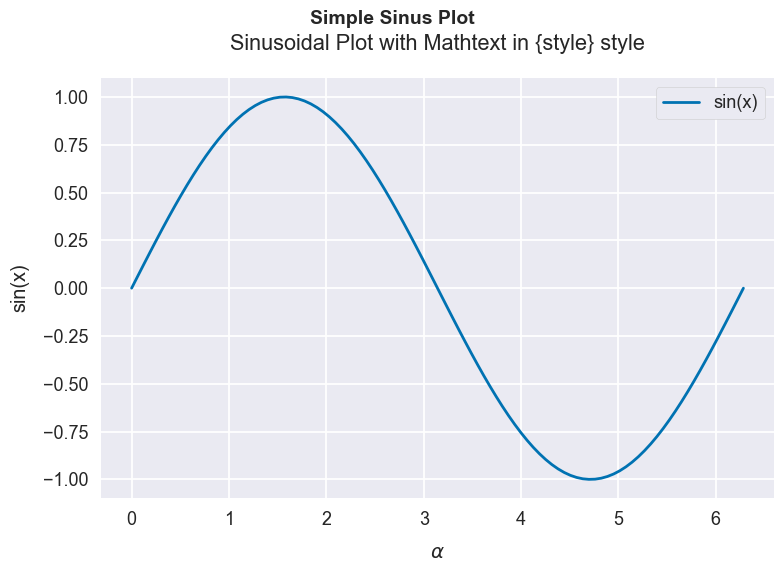

C:\Users\marko\AppData\Local\Temp\ipykernel_11832\4269783665.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style)  # Set the current style


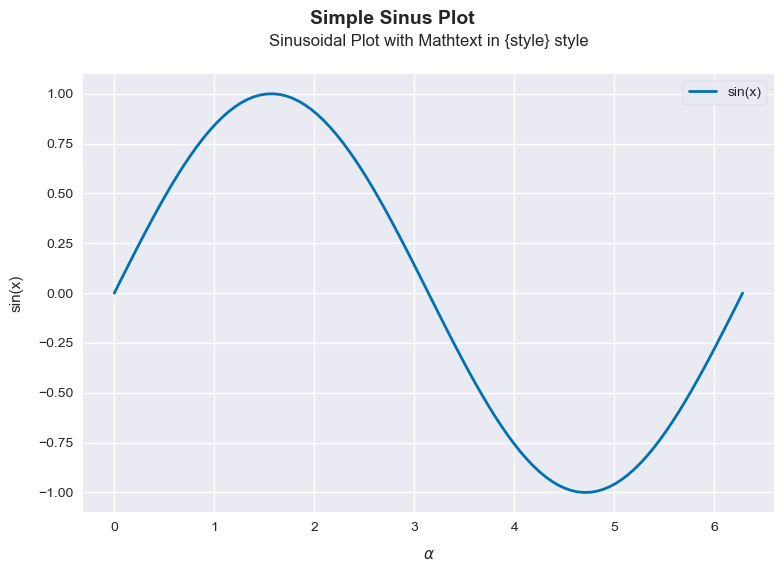

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Set the font family and size for all plots with Mathtext support
plt.rc('font', family='serif', size=12)
plt.rcParams['text.usetex'] = False

# Generate data for the sinusoidal plot
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

# List of research paper styles
styles = ['seaborn-whitegrid', 'seaborn-paper', 'seaborn-talk', 'seaborn-ticks',
          'seaborn-deep', 'seaborn-pastel', 'seaborn-muted', 'seaborn-colorblind',
          'seaborn-darkgrid', 'seaborn-notebook']

# Plot the sinusoidal function with research paper styles
for style in styles:
    plt.style.use(style)  # Set the current style
    
    plt.figure(figsize=(8, 6))  # Set the figure size
    
    # Plot the sinusoidal function
    plt.plot(x, y, label='sin(x)', linewidth=2)
    
    # Add title, subtitle, legend, grid, and other options
    plt.title("Sinusoidal Plot with Mathtext in {style} style", pad=20)
    plt.suptitle("Simple Sinus Plot", fontsize=14, fontweight='bold', y=0.95)
    plt.xlabel(r"$\alpha$", labelpad=10)  # Use Unicode code for "alpha"
    plt.ylabel("sin(x)", labelpad=10)
    plt.legend(frameon=True, framealpha=1, loc='upper right')
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


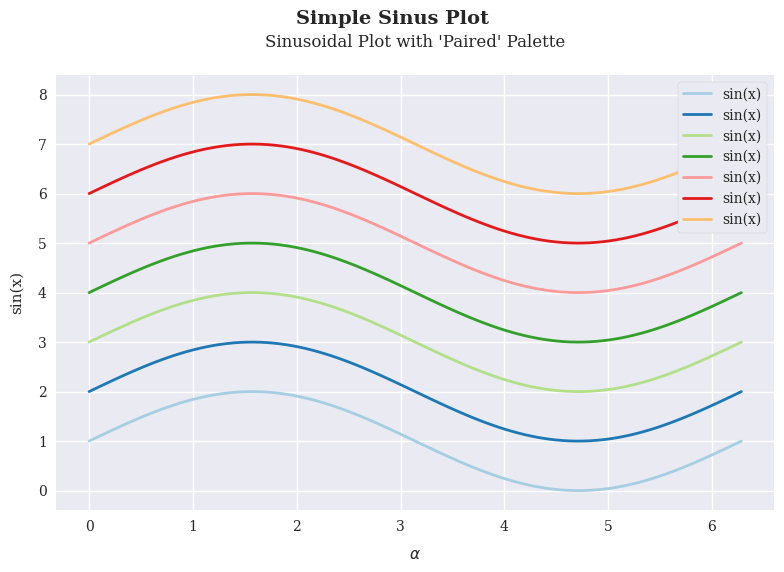

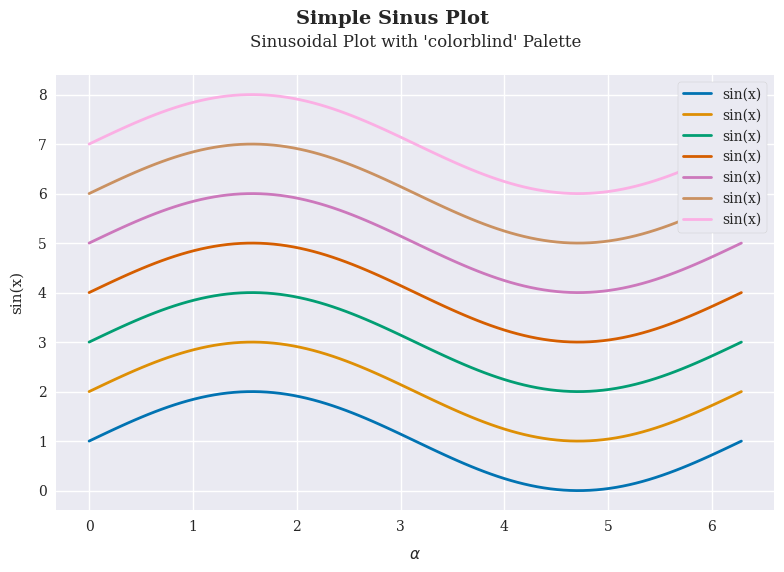

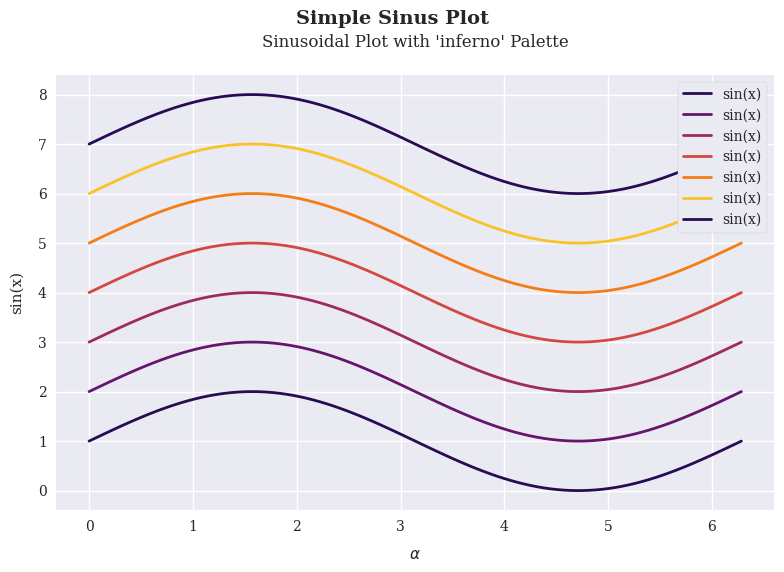

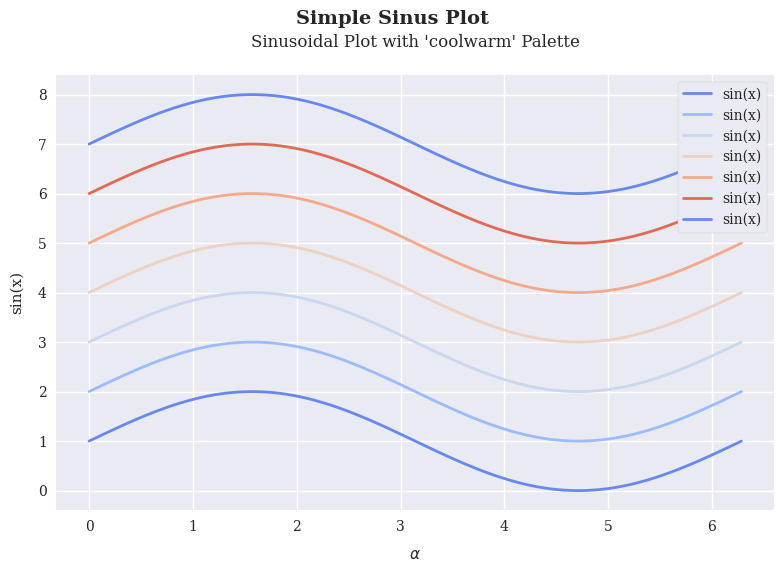

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the font family and size for all plots with Mathtext support
plt.rc('font', family='serif', size=12)
plt.rcParams['text.usetex'] = False

# List of professional color palettes
palettes = ['Paired', 'colorblind', 'inferno', 'coolwarm']

# Generate data for the sinusoidal plot
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

# Plot the sinusoidal function with different color palettes
for palette in palettes:
    sns.set_palette(palette)
    
    plt.figure(figsize=(8, 6))  # Set the figure size
    plt.plot(x, y+1, label='sin(x)', linewidth=2)
    plt.plot(x, y+2, label='sin(x)', linewidth=2)
    plt.plot(x, y+3, label='sin(x)', linewidth=2)
    plt.plot(x, y+4, label='sin(x)', linewidth=2)
    plt.plot(x, y+5, label='sin(x)', linewidth=2)
    plt.plot(x, y+6, label='sin(x)', linewidth=2)
    plt.plot(x, y+7, label='sin(x)', linewidth=2)
    
    # Add title, subtitle, legend, grid, and other options
    plt.title(f"Sinusoidal Plot with '{palette}' Palette", pad=20)
    plt.suptitle("Simple Sinus Plot", fontsize=14, fontweight='bold', y=0.95)
    plt.xlabel(r"$\alpha$", labelpad=10)  # Use Unicode code for "alpha"
    plt.ylabel("sin(x)", labelpad=10)
    plt.legend(frameon=True, framealpha=1, loc='upper right')
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()